In [33]:
#pip install PyAthena

In [34]:
#pip install -U seaborn

In [35]:
#pip install awswrangler

In [36]:
#pip install seaborn==0.11.0

# Import Library

In [6]:
import boto3
import sagemaker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pyathena as pa
import awswrangler as wr 
from pyathena.pandas.cursor import PandasCursor

from sklearn.preprocessing import MultiLabelBinarizer

# Import Data

In [7]:
# CSV data from s3 bucket
#I THINK WE DON'T NEED TO CONVERT TO ATHENA TABLE, WE CAN USE CSV FILE FROM S3 BUCKET
df3 = wr.s3.read_csv(path="s3://s3://ads508patient/patient_folder/dataset.csv")

In [8]:
df3.head(20)

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.730000,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.420000,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.950000,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.640000,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0
5,33181,74489,83,67.0,27.560000,0,Caucasian,M,190.5,Accident & Emergency,...,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,NaN,0
6,82208,49526,83,59.0,57.450000,0,Caucasian,F,165.1,Accident & Emergency,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
7,120995,50129,33,70.0,NaN,0,Caucasian,M,165.0,Accident & Emergency,...,0.0,0.0,1.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
8,80471,10577,118,45.0,NaN,0,Caucasian,M,170.2,Other Hospital,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,1
9,42871,90749,118,50.0,25.710000,0,NaN,M,175.3,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0


In [9]:
df3.tail()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
91708,91592,78108,30,75.0,23.060250,0,Caucasian,M,177.8,Floor,...,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,NaN,0
91709,66119,13486,121,56.0,47.179671,0,Caucasian,F,183.0,Floor,...,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
91710,8981,58179,195,48.0,27.236914,0,Caucasian,M,170.2,Accident & Emergency,...,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
91711,33776,120598,66,NaN,23.297481,0,Caucasian,F,154.9,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
91712,1671,53612,104,82.0,22.031250,1,Caucasian,F,160.0,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,NaN,0


# Exploratory Data Analysis

In [10]:
df3.shape

(91713, 85)

In [11]:
# dataframe information
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [12]:
# Target unique value
df3.hospital_death.unique()

array([0, 1])

In [13]:
# Count of target variable
df3.hospital_death.value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

In [15]:
# Data description
df3.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Unnamed: 83,hospital_death
count,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,88993.000000,...,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,0.0,91713.000000
mean,65606.079280,65537.131464,105.669262,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,84.028340,...,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,0.086302
std,37795.088538,37811.252183,62.854406,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,25.011497,...,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,0.280811
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,38.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,32852.000000,32830.000000,47.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,66.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
50%,65665.000000,65413.000000,109.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,80.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
75%,98342.000000,98298.000000,161.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,97.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
max,131051.000000,131051.000000,204.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,186.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000


In [16]:
#Correlation
df3.corr()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Unnamed: 83,hospital_death
encounter_id,1.000000,-0.009575,-0.004532,-0.003990,-0.001068,0.002036,-0.005400,-0.000992,-0.000570,-0.004376,...,0.001907,0.007601,0.003402,-0.000972,-0.001707,-0.002172,-0.001176,-0.004646,NaN,-0.005243
patient_id,-0.009575,1.000000,-0.007075,0.006343,-0.001380,0.001387,0.002902,-0.001770,-0.004412,0.000275,...,-0.002426,0.001307,0.000434,-0.001667,0.000548,0.000844,0.002333,-0.003065,NaN,0.004877
hospital_id,-0.004532,-0.007075,1.000000,-0.008673,0.012874,0.052123,0.027895,0.004526,-0.001285,0.026314,...,-0.004947,0.002962,0.011978,0.001362,0.000146,-0.002992,0.002588,-0.004730,NaN,-0.001255
age,-0.003990,0.006343,-0.008673,1.000000,-0.087077,0.067320,-0.109937,-0.024257,0.049872,-0.127252,...,-0.029477,-0.028065,0.077908,-0.020061,0.025007,0.030310,0.023335,0.025924,NaN,0.111017
bmi,-0.001068,-0.001380,0.012874,-0.087077,1.000000,0.015921,-0.056316,0.001403,-0.001531,0.877339,...,-0.020434,-0.002377,0.172943,-0.001855,-0.031144,-0.013375,-0.010017,-0.043380,NaN,-0.031247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
leukemia,-0.002172,0.000844,-0.002992,0.030310,-0.013375,-0.017587,0.001718,0.001014,0.041853,-0.012755,...,-0.002471,-0.005373,0.002890,-0.001567,0.134934,1.000000,0.031380,0.006210,NaN,0.029788
lymphoma,-0.001176,0.002333,0.002588,0.023335,-0.010017,-0.008215,0.008370,-0.002336,0.013954,-0.005197,...,0.021529,0.001516,-0.002326,0.001689,0.103201,0.031380,1.000000,0.014749,NaN,0.018722
solid_tumor_with_metastasis,-0.004646,-0.003065,-0.004730,0.025924,-0.043380,0.015369,0.004921,-0.014381,0.036581,-0.039255,...,-0.001611,-0.005890,-0.013122,0.007240,0.269653,0.006210,0.014749,1.000000,NaN,0.051105
Unnamed: 83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#Duplicate rows
df3.duplicated().sum()

0

In [19]:
#gender value count
df3.gender.value_counts()

M    49469
F    42219
Name: gender, dtype: int64

In [20]:
# hospital death value count
df3.hospital_death.value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

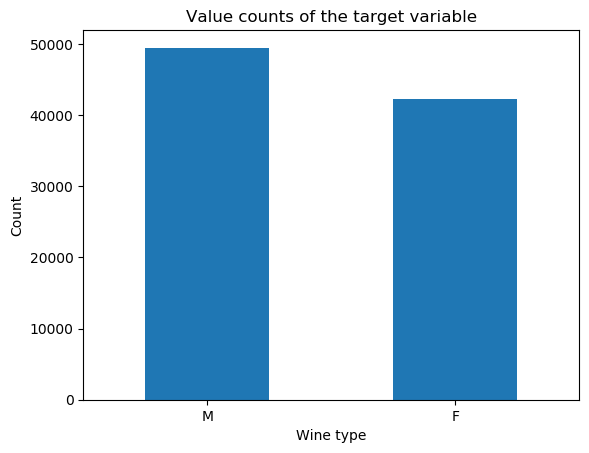

In [21]:
# bar plot for gender variable
df3.gender.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xlabel("Wine type")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

# Histogram of variable Age

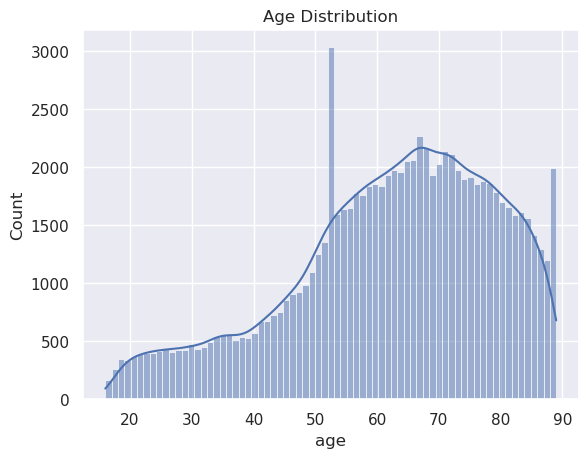

In [22]:
#histogram for age variable
sns.set(style="darkgrid")
sns.histplot(data=df3, x="age", kde=True).set(title='Age Distribution')
plt.show()

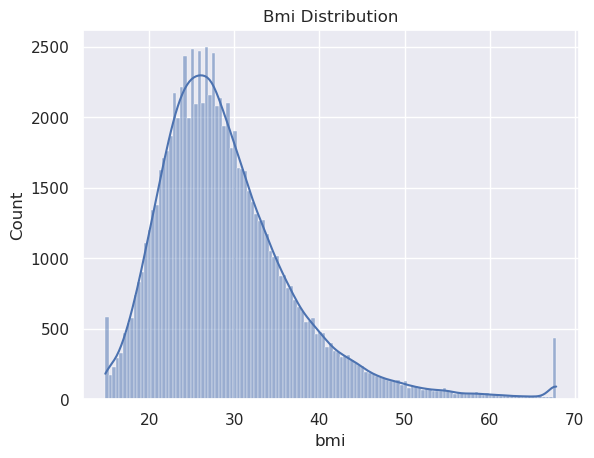

In [23]:
#histogram for bmi variable
sns.set(style="darkgrid")
sns.histplot(data=df3, x="bmi", kde=True).set(title='Bmi Distribution')
plt.show()

# Visualizing missing values

<Figure size 600x600 with 0 Axes>

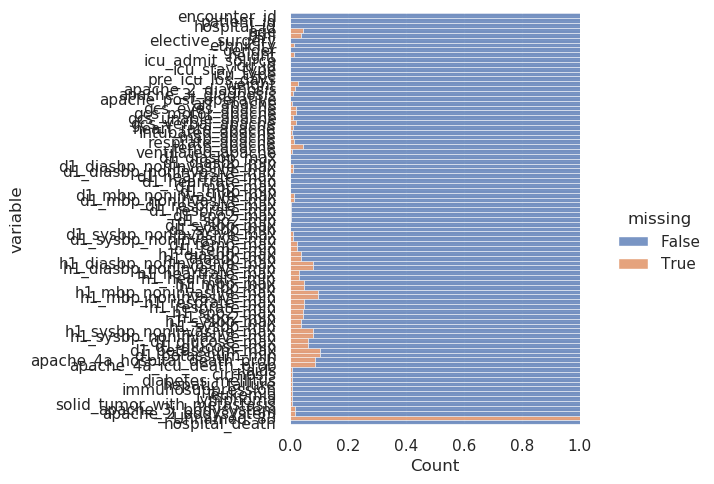

In [24]:
#heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=df3.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)
plt.show()

# Relationships between Target Variable and Independent Variable

## Relationship between hospital_death and gender

### Contigency table

In [25]:
crosstab_01 = pd.crosstab(df3['gender'], df3['hospital_death'])
crosstab_01

hospital_death,0,1
gender,,
F,38488,3731
M,45293,4176


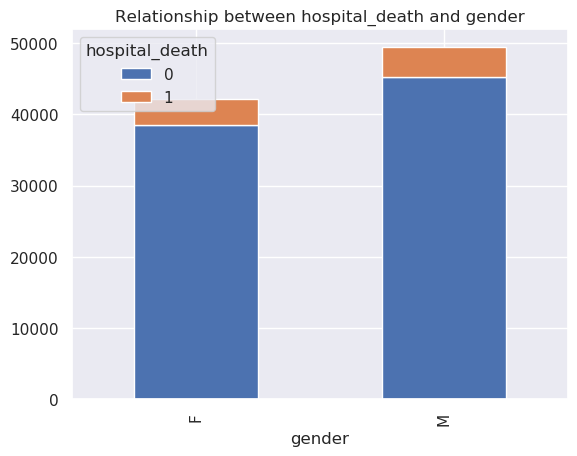

In [26]:
crosstab_01.plot(kind='bar', stacked =True,title='Relationship between hospital_death and gender')
plt.show()

## Relationship between hospital_death and bodysystem

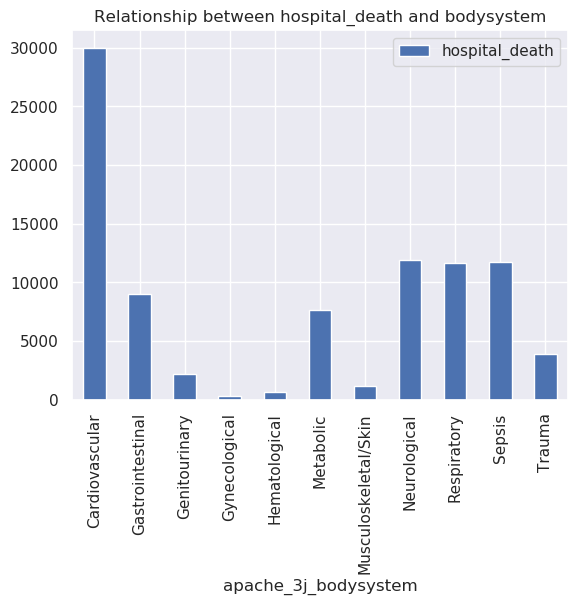

In [27]:
df3[['apache_3j_bodysystem','hospital_death']].groupby('apache_3j_bodysystem').agg('count').plot(kind='bar',stacked =True,title='Relationship between hospital_death and bodysystem')
plt.show()

## Relationship between hospital_death and ethnicity

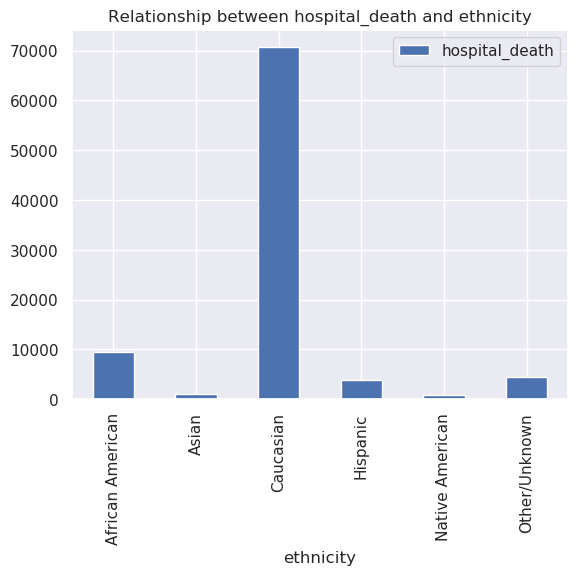

In [28]:
df3[['ethnicity','hospital_death']].groupby('ethnicity').agg('count').plot(kind='bar', stacked =True,title='Relationship between hospital_death and ethnicity')
plt.show()

## Relationship between death with ethnicity and gender

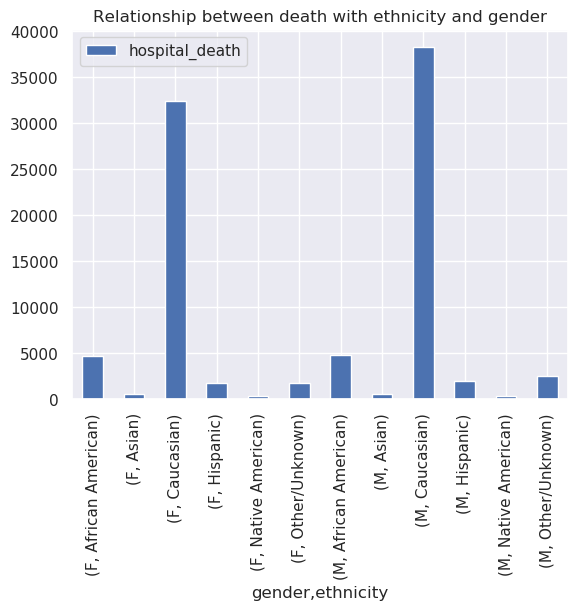

In [29]:
df3[['gender','ethnicity','hospital_death']].groupby(['gender','ethnicity']).count().plot(kind='bar', stacked =True,title='Relationship between death with ethnicity and gender')
plt.show()

## Relationship between death and bmi

In [32]:
#Relationship between death and bmi
